In [30]:
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from transformers import ViTForImageClassification, ViTFeatureExtractor, ViTConfig
from torchvision import transforms
import os

#optional
import matplotlib.pyplot as plt

# LOAD DATASET

In [31]:
# Load train and validation data
train_df = pd.read_csv('datasets/CheXpert-v1.0-small/train.csv')
valid_df = pd.read_csv('datasets/CheXpert-v1.0-small/valid.csv')

print("dataset loaded")

dataset loaded


In [32]:
# Display first 5 rows of validation data
print("train Data:")
print(train_df.head())

train Data:
                                                Path     Sex  Age  \
0  CheXpert-v1.0-small/train/patient00001/study1/...  Female   68   
1  CheXpert-v1.0-small/train/patient00002/study2/...  Female   87   
2  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
3  CheXpert-v1.0-small/train/patient00002/study1/...  Female   83   
4  CheXpert-v1.0-small/train/patient00003/study1/...    Male   41   

  Frontal/Lateral AP/PA  No Finding  Enlarged Cardiomediastinum  Cardiomegaly  \
0         Frontal    AP         1.0                         NaN           NaN   
1         Frontal    AP         NaN                         NaN          -1.0   
2         Frontal    AP         NaN                         NaN           NaN   
3         Lateral   NaN         NaN                         NaN           NaN   
4         Frontal    AP         NaN                         NaN           NaN   

   Lung Opacity  Lung Lesion  Edema  Consolidation  Pneumonia  Atelectasis  \
0       

In [44]:
print("Jumlah data unik pada setiap kolom di train_df (kecuali 'Path' dan 'Age'):")
unique_counts = train_df.loc[:, ~train_df.columns.isin(['Path', 'Age'])].nunique()
unique_values = train_df.loc[:, ~train_df.columns.isin(['Path', 'Age'])].apply(lambda x: x.unique().tolist())
result = pd.DataFrame({'Unique Count': unique_counts, 'Unique Values': unique_values})
print(result)


Jumlah data unik pada setiap kolom di train_df (kecuali 'Path' dan 'Age'):
                            Unique Count              Unique Values
Sex                                    2            [0.0, 1.0, nan]
Frontal/Lateral                        2         [Frontal, Lateral]
AP/PA                                  4  [0.0, nan, 1.0, 2.0, 3.0]
No Finding                             1                 [1.0, nan]
Enlarged Cardiomediastinum             3      [nan, 0.0, 1.0, -1.0]
Cardiomegaly                           3      [nan, -1.0, 0.0, 1.0]
Lung Opacity                           3      [nan, 1.0, 0.0, -1.0]
Lung Lesion                            3      [nan, 1.0, -1.0, 0.0]
Edema                                  3      [nan, -1.0, 1.0, 0.0]
Consolidation                          3      [nan, -1.0, 0.0, 1.0]
Pneumonia                              3      [nan, 0.0, -1.0, 1.0]
Atelectasis                            3      [nan, -1.0, 1.0, 0.0]
Pneumothorax                           3 

In [34]:
# Ubah label 'Sex' menjadi boolean: 1 untuk Male, 0 untuk Female
train_df['Sex'] = train_df['Sex'].map({'Male': 1, 'Female': 0})
valid_df['Sex'] = valid_df['Sex'].map({'Male': 1, 'Female': 0})

print("Label 'Sex' berhasil diubah menjadi boolean.")

Label 'Sex' berhasil diubah menjadi boolean.


In [35]:
# Ubah label 'AP/PA' menjadi numerik: 0 untuk AP, 1 untuk PA, 2 untuk LL, dan 3 untuk R
train_df['AP/PA'] = train_df['AP/PA'].map({'AP': 0, 'PA': 1, 'LL': 2, 'RL': 3})
valid_df['AP/PA'] = valid_df['AP/PA'].map({'AP': 0, 'PA': 1, 'LL': 2, 'RL': 3})

print("Label 'AP/PA' berhasil diubah menjadi numerik.")

Label 'AP/PA' berhasil diubah menjadi numerik.


In [36]:
# Filter hanya kolom 'Sex' dan 'AP/PA'
filtered_df = train_df[['Sex', 'AP/PA']]

# Hitung jumlah nilai unik dan daftar nilai unik
unique_counts = filtered_df.nunique()
unique_values = filtered_df.apply(lambda x: [v if pd.notna(v) else 'Unknown' for v in x.unique()])

# Buat DataFrame hasil
filtered_result = pd.DataFrame({'Unique Count': unique_counts, 'Unique Values': unique_values})
print(filtered_result)

       Unique Count                  Unique Values
Sex               2            [0.0, 1.0, Unknown]
AP/PA             4  [0.0, Unknown, 1.0, 2.0, 3.0]


sex :
- 0 female
- 1 male

ap/pa :
- 0 AP
- 1 PA
- 2 LL
- 3 R

In [37]:
# Display label distribution
print("\nLabel Distribution in Validation Data:")
print(train_df.iloc[:, 5:].apply(lambda x: x.value_counts(dropna=False)))


Label Distribution in Validation Data:
      No Finding  Enlarged Cardiomediastinum  Cardiomegaly  Lung Opacity  \
-1.0         NaN                       12403          8087          5598   
 0.0         NaN                       21638         11116          6599   
 1.0     22381.0                       10798         27000        105581   
 NaN    201033.0                      178575        177211        105636   

      Lung Lesion   Edema  Consolidation  Pneumonia  Atelectasis  \
-1.0         1488   12984          27742      18770        33739   
 0.0         1270   20726          28097       2799         1328   
 1.0         9186   52246          14783       6039        33376   
 NaN       211470  137458         152792     195806       154971   

      Pneumothorax  Pleural Effusion  Pleural Other  Fracture  Support Devices  
-1.0          3145             11628           2653       642             1079  
 0.0         56341             35396            316      2512             61

## korelasi (train)

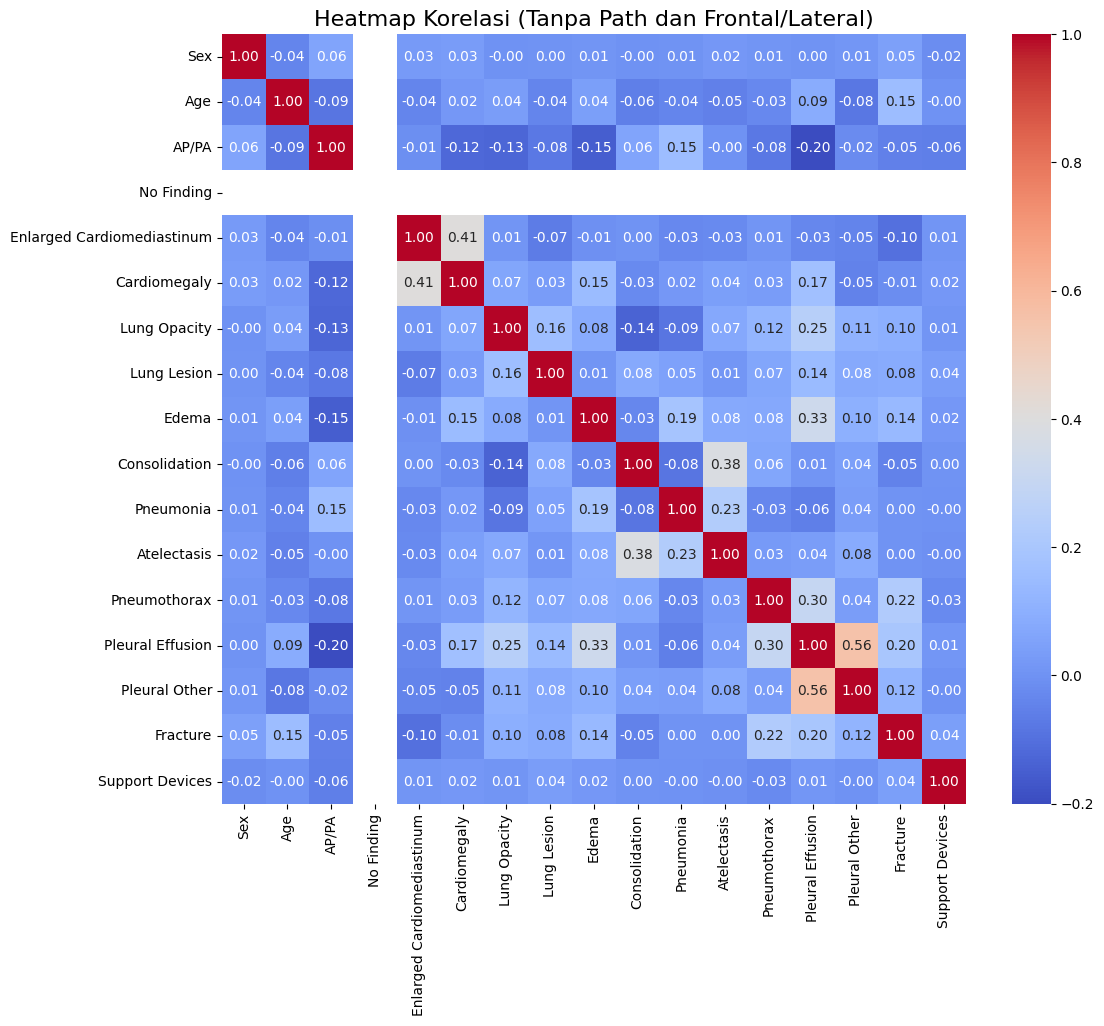

In [41]:
import seaborn as sns

# Filter kolom kecuali 'Path' dan 'Frontal/Lateral'
filtered_labels = train_df.loc[:, ~train_df.columns.isin(['Path', 'Frontal/Lateral'])]

# Hitung matriks korelasi
correlation_table = filtered_labels.corr()

# Membuat heatmap dari tabel korelasi
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_table, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Menambahkan judul
plt.title("Heatmap Korelasi (Tanpa Path dan Frontal/Lateral)", fontsize=16)
plt.show()

## Membuat datatest

In [30]:
# Bagi valid_df menjadi validasi dan test set
valid_df, test_df = train_test_split(valid_df, test_size=0.10, random_state=42)
print("valid_df menjadi validasi dan test set")

valid_df menjadi validasi dan test set


In [31]:
print(f"Jumlah data train: {len(train_df)}")
print(f"Jumlah data validasi: {len(valid_df)}")
print(f"Jumlah data test: {len(test_df)}\n")

print("train_df :")
print(f"- Frontal: {train_df['Frontal/Lateral'].value_counts().get('Frontal', 0)}")
print(f"- Lateral: {train_df['Frontal/Lateral'].value_counts().get('Lateral', 0)}\n")

print("validasi :")
print(f"- Frontal: {train_df['Frontal/Lateral'].value_counts().get('Frontal', 0)}")
print(f"- Lateral: {train_df['Frontal/Lateral'].value_counts().get('Lateral', 0)}\n")

Jumlah data train: 223414
Jumlah data validasi: 210
Jumlah data test: 24

train_df :
- Frontal: 191027
- Lateral: 32387

validasi :
- Frontal: 191027
- Lateral: 32387



=== Informasi Data Sampel ===
Path: CheXpert-v1.0-small/train/patient54838/study1/view1_frontal.jpg
Jenis Kelamin: Male
Usia: 21
View: Frontal

Label Penyakit:
No Finding: 1.0
Enlarged Cardiomediastinum: nan
Cardiomegaly: nan
Lung Opacity: nan
Lung Lesion: nan
Edema: nan
Consolidation: nan
Pneumonia: nan
Atelectasis: nan
Pneumothorax: 0.0
Pleural Effusion: nan
Pleural Other: nan
Fracture: 0.0
Support Devices: nan


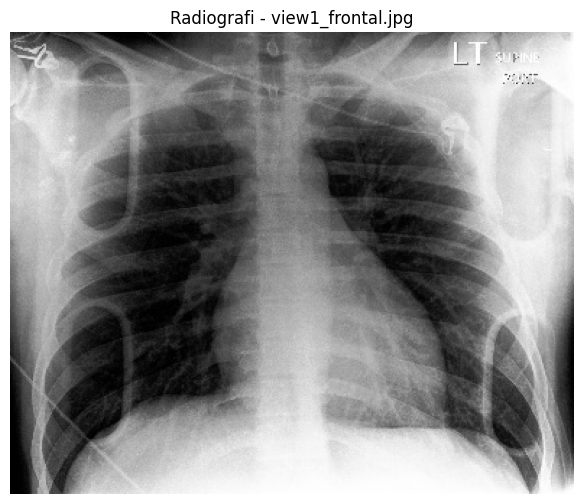

In [16]:
# Pilih 1 sampel acak
random_sample = train_df.sample(1).iloc[0]

# Tampilkan informasi data
print("=== Informasi Data Sampel ===")
print(f"Path: {random_sample['Path']}")
print(f"Jenis Kelamin: {random_sample['Sex']}")
print(f"Usia: {random_sample['Age']}")
print(f"View: {random_sample['Frontal/Lateral']}")
print("\nLabel Penyakit:")
for col in train_df.columns[5:]:  # Kolom penyakit dimulai dari indeks 5
    print(f"{col}: {random_sample[col]}")

# Load dan tampilkan gambar
try:
    img_path = 'datasets/' + random_sample['Path']
    img = Image.open(img_path).convert('RGB')
    
    plt.figure(figsize=(8, 6))
    plt.imshow(img, cmap='gray')
    plt.title(f"Radiografi - {os.path.basename(img_path)}")
    plt.axis('off')
    plt.show()
    
except FileNotFoundError:
    print(f"\nERROR: File tidak ditemukan di path: {img_path}")
    print("Pastikan:")
    print("1. Dataset gambar sudah di-download")
    print("2. Path relatif/absolut benar")
    print("3. Struktur folder sesuai dengan kolom 'Path'")
except Exception as e:
    print(f"\nERROR: {str(e)}")

# Preprocessing Data
## Handle Missing Values dan Label Tidak Pasti (-1)

In [10]:
def preprocess_labels(df):
    # Replace -1 (uncertain) with 1, 0, or NaN based on strategy
    # Contoh: Ubah -1 menjadi 0 (anggap sebagai negatif)
    df.iloc[:, 5:] = df.iloc[:, 5:].replace(-1, 0)  
    # Fill NaN with 0 (anggap sebagai negatif)
    df.iloc[:, 5:] = df.iloc[:, 5:].fillna(0)  
    return df

train_df = preprocess_labels(train_df)
valid_df = preprocess_labels(valid_df)

## Transformasi Gambar

In [8]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

# Membuat Custom Dataset Class

In [38]:
class CheXpertDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Path']
        image = Image.open(img_path).convert('RGB')  # Pastikan gambar RGB
        labels = torch.FloatTensor(self.dataframe.iloc[idx, 5:].values)  # Ambil kolom label mulai dari indeks 5

        if self.transform:
            image = self.transform(image)

        return image, labels

# Create datasets and dataloaders
train_dataset = CheXpertDataset(train_df, transform=transform)
valid_dataset = CheXpertDataset(valid_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Memuat Model Vision Transformer (ViT)

In [42]:
# Load pre-trained ViT model
model_name = 'google/vit-base-patch16-224'
config = ViTConfig.from_pretrained(model_name)
config.num_labels = 14  # Sesuaikan dengan 14 kelas di CheXpert

model = ViTForImageClassification.from_pretrained(
    model_name,
    config=config,
    ignore_mismatched_sizes=True  # Untuk menyesuaikan head klasifikasi
)

# Ganti classification head untuk multi-label
model.classifier = nn.Sequential(
    nn.Linear(config.hidden_size, 14),
    nn.Sigmoid()  # Untuk output multi-label
)

# Pindahkan model ke GPU jika tersedia
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

NameError: name 'init_empty_weights' is not defined